# EE 511 Assignment 2 - PartII
University of Washington<br>
Code by John Ragland and Doruk Arisoy<br>
Winter 2021

In [1]:
# Supress Warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import tools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

tools.check_sklearn_version()

# Some magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## \[Step 3\] Load training, validation and testing data

In [2]:
train, valid, test = tools.load_data()

## \[Step 4\] One variable least squares linear regression 

In [3]:
area_label = 'Gr Liv Area'
price_label = 'SalePrice'

area_train = train[area_label].to_numpy()
area_valid = valid[area_label].to_numpy()
area_test = test[area_label].to_numpy()
price_train = train[price_label].to_numpy()
price_valid = valid[price_label].to_numpy()
price_test = test[price_label].to_numpy()

In [4]:
small_model = LinearRegression().fit(area_train.reshape(-1, 1), price_train)

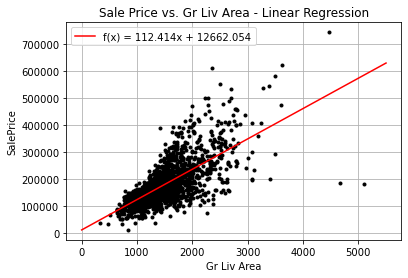

In [5]:
x = np.linspace(0, 5500, 100)
y = small_model.coef_[0] * x + small_model.intercept_

plt.xlabel(area_label)
plt.ylabel(price_label)
plt.plot(area_train, price_train, '.', color='black')
plt.plot(x, y, '-r', label="f(x) = %.3fx + %.3f" % (small_model.coef_[0], small_model.intercept_))
plt.legend()
plt.title('Sale Price vs. Gr Liv Area - Linear Regression')
plt.grid()

In [6]:
price_predicted = small_model.predict(area_valid.reshape(-1, 1))
print('RMSE = $%.2f' % mean_squared_error(price_valid, price_predicted, squared=False))

RMSE = $56299.05


## \[Step 5\] Adding more features to the simple model

In [8]:
train_without_price = train.drop(price_label, 1).to_numpy()
valid_without_price = valid.drop(price_label, 1).to_numpy()
test_without_price = test.drop(price_label, 1).to_numpy()

In [9]:
large_model = LinearRegression().fit(train_without_price, price_train)
pred = large_model.predict(valid_without_price)
print('RMSE = $%.2f' % mean_squared_error(price_valid, pred, squared=False))

RMSE = $26700.24


## \[Step 6\] Adding L1 regularization

In [10]:
# Search for best value of alpha
alphas = np.linspace(0,200,100)
mse_valid = []
mse_train = []
for alpha in alphas:
    large_model_lasso = Lasso(alpha=alpha)
    large_model_lasso.fit(train_without_price, price_train)
    pred_valid = large_model_lasso.predict(valid_without_price)
    pred_train = large_model_lasso.predict(train_without_price)
    mse_valid.append(mean_squared_error(price_valid, pred_valid, squared=False))
    mse_train.append(mean_squared_error(price_train, pred_train, squared=False))

Best Performance for α = 40.404
Best RMSE = $24204.72


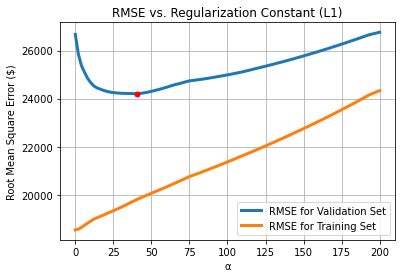

In [16]:
best_alpha = alphas[np.argmin(mse_valid)]

plt.plot(alphas,mse_valid, linewidth=3)
plt.plot(alphas,mse_train, linewidth=3)
plt.plot(best_alpha,np.min(mse_valid),'r.',markersize=10)
plt.legend(['RMSE for Validation Set','RMSE for Training Set'])
plt.xlabel('α')
plt.ylabel('Root Mean Square Error ($)')
plt.title('RMSE vs. Regularization Constant (L1)')
plt.grid()

print('Best Performance for α = %.3f' % best_alpha)
print('Best RMSE = $%.2f' % np.min(mse_valid))

In [12]:
# Train Model with optimum alpha
large_model_lasso = Lasso(alpha=best_alpha)
large_model_lasso.fit(train_without_price, price_train)

Lasso(alpha=40.40404040404041)

Overfitting occurs when the model trains specifically for the training set and gets worse at generalizing. <br>
We can directly see where the overfitting occurs in our model by looking at the RMSE vs Regularization graph. As the ruglarization constant decreases, the RMSE loss constantly decreases for the training set. The same is not the case for the validation set. When the regularization constant alpha is under ~40, we see that the model's performance drops on the validation set as alpha continues to decrease. This is telling us that when alpha is under ~40, our model starts overfitting to the training set. It becomes really good at predicting the training set but starts performing poorly on validation set. Since we want our model to perform the best with any data and not just training data, we selected alpha to be 40.404.

## \[Step 7\] Testing the Models

### Single Variable Model

In [13]:
pred_test = small_model.predict(area_test.reshape(-1, 1))
rmse_small_model = mean_squared_error(pred_test, price_test, squared=False)
print('RMSE for Simple Model: $%.2f' % rmse_small_model)

RMSE for Simple Model: $55457.72


### Multiple Variables - No Regularization

In [14]:
test_without_price = test.drop(price_label, 1).to_numpy()
pred = large_model.predict(test_without_price)
print('RMSE for multivariate model: $%.2f' % mean_squared_error(price_test, pred, squared=False))

RMSE for multivariate model: $36034.59


### Multiple Variables with optimum L1 Regularization

In [15]:
pred_test = large_model_lasso.predict(test_without_price)
print('RMSE for multivariate model with L1 regularization: $%.2f' % mean_squared_error(price_test, pred_test, squared=False))

RMSE for multivariate model with L1 regularization: $33752.73


### Summary of Testing Results
| Model | RMSE on Validation | RMSE on Testing |
| :- | -: | -: |
| Single Variable | $56.299.05 | $55,457.72 |
| Multi Variable | $26,700.24 | $36,034.59 |
| L1 Regularization | $24,204.72 | $33,752.73 |